# Imports

In [1]:
from os import walk 
from os.path import join
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup 

from PIL import Image
from wordcloud import WordCloud

from collections import Counter

from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import gensim
import matplotlib.pyplot as plt
import seaborn as sns

# File Paths

In [2]:
SPAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/spam_2'
HAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/ham_1'
HAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/ham_2'

SPAM_CAT = 1
HAM_CAT = 0

CUSTOM_FONT = 'UniversityProject_SpamFilter/wordcloud_resources/OpenSansCondensed-Bold.ttf'
WORD_CLOUD = 'UniversityProject_SpamFilter/wordcloud_resources/word_cloud.png'
THUMBS_UP = 'UniversityProject_SpamFilter/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN = 'UniversityProject_SpamFilter/wordcloud_resources/thumbs-down.png'
X_ICON = 'UniversityProject_SpamFilter/wordcloud_resources/x-icon.png'

In [3]:
def email_body_generator(path): 
                                    #walk provides a tuple 
    for root, dirnames, filenames, in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body= False
            lines = []
            
            #extracts email body 
            for line in stream: 
                if is_body: 
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            #loops over the file in the directory and returns the file name and associated email body 
            yield file_name, email_body

In [4]:
def dataframe_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name) 
    
    return pd.DataFrame(rows, index=row_names) 

In [5]:
spam_emails = dataframe_from_directory(SPAM_1_FILEPATH, SPAM_CAT)
spam_emails = spam_emails.append(dataframe_from_directory(SPAM_2_FILEPATH, SPAM_CAT))
ham_emails = dataframe_from_directory(HAM_1_FILEPATH, HAM_CAT)
ham_emails = ham_emails.append(dataframe_from_directory(HAM_2_FILEPATH, HAM_CAT))
df_data = pd.concat([spam_emails, ham_emails])

In [6]:
df_data[df_data.MESSAGE.str.len() == 0].index
df_data.drop(['cmds'], inplace = True)
df_data['Length']=df_data['MESSAGE'].apply(len)

In [7]:
amount_of_SPAM = df_data.CATEGORY.value_counts()[1]
amount_of_HAM = df_data.CATEGORY.value_counts()[0]

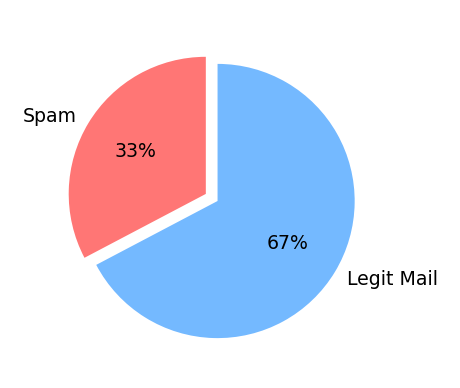

In [8]:
category_names =['Spam', 'Legit Mail']
size = [amount_of_SPAM, amount_of_HAM]
custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(size, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours, explode=[0,0.1])
plt.show()

In [9]:
documents_ids = range(0, len(df_data.index))
df_data['Doc_ID'] = documents_ids
df_data['File_Name'] = df_data.index
df_data = df_data.set_index('Doc_ID')
#df_data.head()

----------------------------------------------------------------------------------------------------------------------
Examples of stop words in English are “a”, “the”, “is”, “are” and etc. 
Removing stop words is done to eliminate words that are so commonly used that they carry very little useful information.

The below, is adding multiple dictionaries from different libraries together, in addition to common html words found in the messages.

----------------------------------------------------------------------------------------------------------------------

In [10]:
sklearn_stopwords = set(text.ENGLISH_STOP_WORDS)
gensim_stopwords = set(gensim.parsing.preprocessing.STOPWORDS)
nltk_stop_words = stopwords.words('english')

gensim_and_sklearn = sklearn_stopwords.union(gensim_stopwords)
libary_stopwords = gensim_and_sklearn.union(nltk_stop_words)

all_stop_words = {'url', 'http', '\n', '[html', 'html', 'tr', 'td', 'https', 'br', 'ign', 'err', 'mpt','[', ']' }
all_stop_words.update(libary_stopwords)

capital_sw = [each_string.title() for each_string in all_stop_words]
uppercase_sw = [each_string.upper() for each_string in all_stop_words]

all_stop_words.update(capital_sw)
all_stop_words.update(uppercase_sw)

#print(all_stop_words)

In [11]:
def clean_msg_nohtml(message, #stemmer = PorterStemmer(),
                  stop_words = set(all_stop_words)): 
    
    # Remove HTML tags 
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    #splits up  the individual words
    words = word_tokenize(cleaned_text)
    
    filtered_words = []
    
    for word in words: 
        if word not in stop_words and word.isalpha():
            filtered_words.append(word)
    
    return filtered_words

# DATA VISUALISATION

In [12]:
nested_list = df_data.MESSAGE.apply(clean_msg_nohtml)

/Users/rachaeldoherty/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [13]:
#nested_list

In [14]:
docs_id_SPAM = df_data[df_data.CATEGORY ==1].index
docs_id_HAM = df_data[df_data.CATEGORY ==0].index

nested_list_HAM = nested_list.loc[docs_id_HAM]
nested_list_SPAM = nested_list.loc[docs_id_SPAM]
flat_list_HAM = [item for sublist in nested_list_HAM for item in sublist]

#total number of unique words in the non spam messages
HAM_words = pd.Series(flat_list_HAM).value_counts() 
flat_list_SPAM = [item for sublist in nested_list_SPAM for item in sublist]

#total number of unique words in the spam messages
SPAM_words = pd.Series(flat_list_SPAM).value_counts() 

In [15]:
SPAM_str = ' ' .join(flat_list_SPAM)
HAM_str = ' ' .join(flat_list_HAM)
full_str = SPAM_str + HAM_str

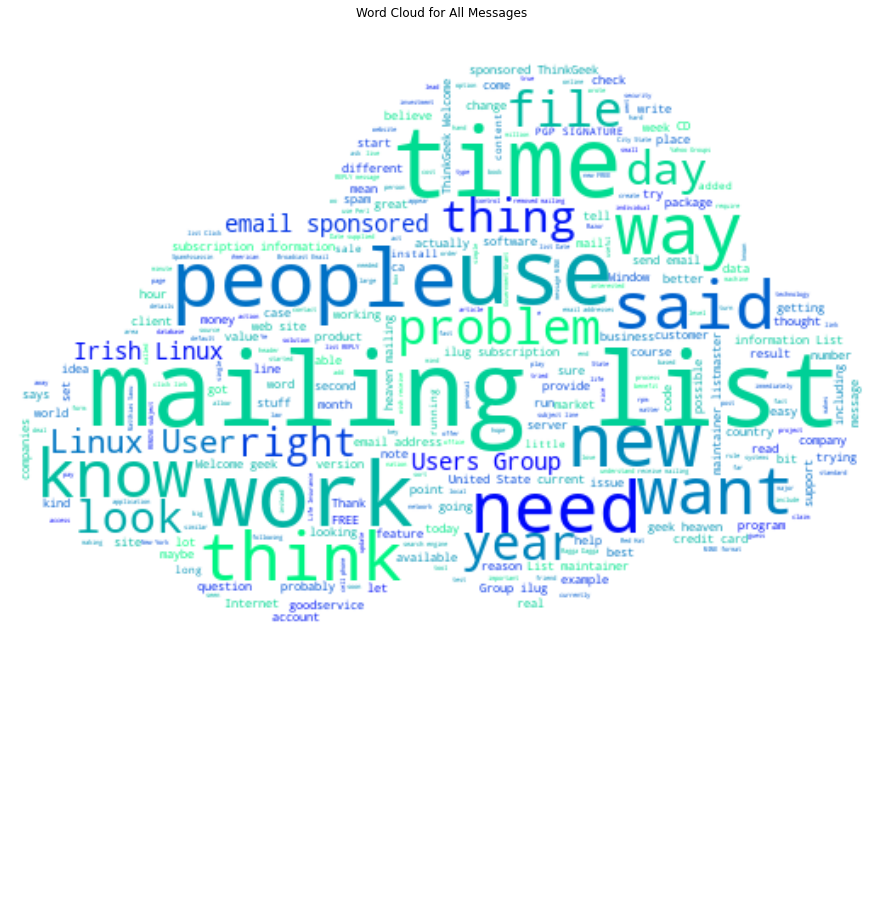

In [16]:
icon = Image.open(WORD_CLOUD)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 1000, colormap = 'winter')

word_cloud.generate(full_str)

plt.figure(figsize=[32,16])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for All Messages')
plt.axis('off')
plt.show()

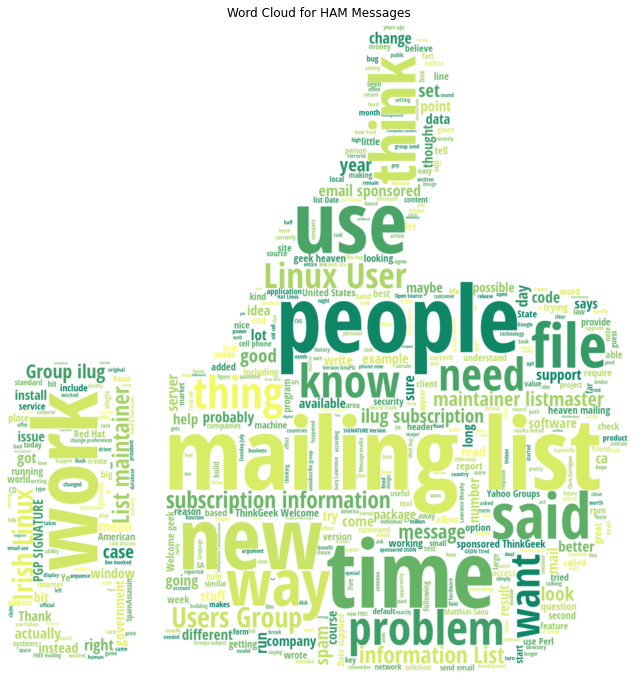

In [17]:
icon = Image.open(THUMBS_UP)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 


word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 500, colormap = 'summer',
                       font_path = CUSTOM_FONT, max_font_size = 300)

word_cloud.generate(HAM_str)

plt.figure(figsize=[20,12])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for HAM Messages')

plt.axis('off')
plt.show()

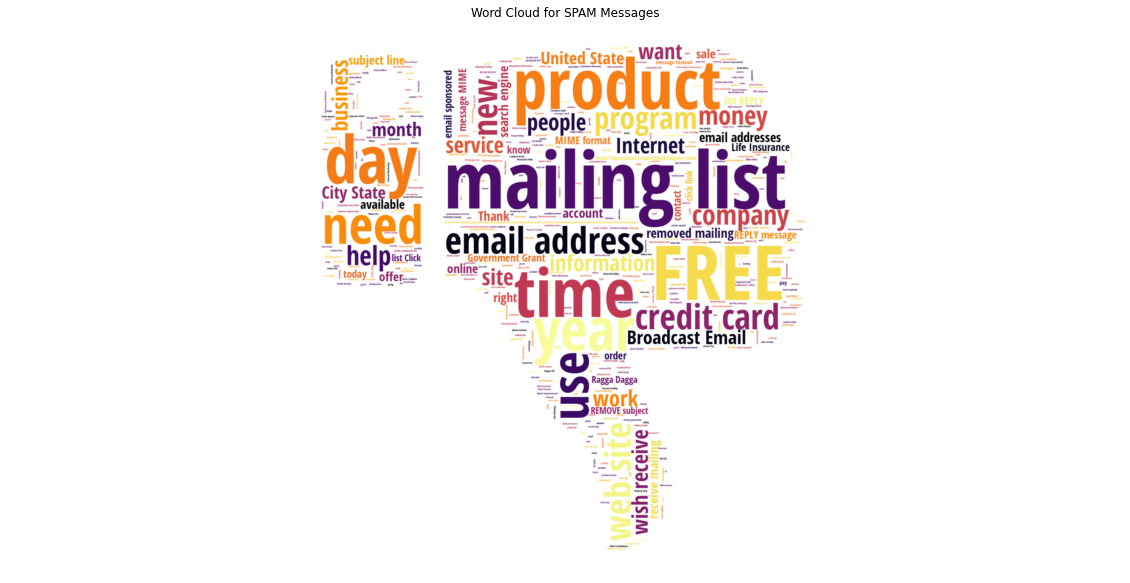

In [18]:
icon = Image.open(THUMBS_DOWN)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 500, colormap = 'inferno', 
                       font_path = CUSTOM_FONT, max_font_size = 300)

word_cloud.generate(SPAM_str)

plt.figure(figsize=[20,12])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for SPAM Messages')
plt.axis('off')
plt.show()

### Distribution by Length of Text within both HAM and SPAM Messages: 

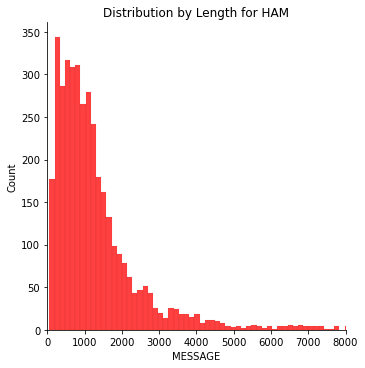

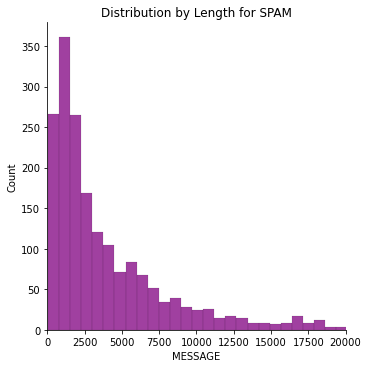

In [19]:
ham = df_data[df_data['CATEGORY'] == HAM_CAT]['MESSAGE'].str.len()
sns.displot(ham, label='Ham', color='red')
plt.xlim(0, 8000)
plt.title('Distribution by Length for HAM')

plt.draw()


spam = df_data[df_data['CATEGORY'] == SPAM_CAT]['MESSAGE'].str.len()
sns.displot(spam, label='Spam', color='purple')
plt.xlim(0, 20000)
plt.title('Distribution by Length for SPAM')
plt.draw()
plt.legend().set_visible(False)



# plt.savefig('Distrbution of word by length.png')
# transform/ normalise this range from 0 - 1 

In [20]:
df_data_1 = pd.DataFrame.from_dict(Counter(SPAM_str.split()).most_common(10))
df_data_1 = df_data_1.rename(columns={0: "words of spam", 1 : "count_"})

df_data_2 = pd.DataFrame.from_dict(Counter(HAM_str.split()).most_common(10))
df_data_2 = df_data_2.rename(columns={0: "words of ham", 1 : "count_"})

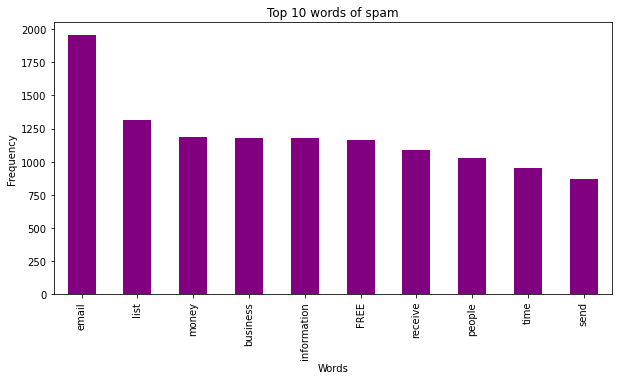

In [21]:
df_data_1.plot.bar(legend = False, color = 'purple',figsize = (10,5))
y_pos = np.arange(len(df_data_1["words of spam"]))
plt.xticks(y_pos, df_data_1["words of spam"])
plt.title('Top 10 words of spam')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.legend().set_visible(False)
plt.show()

#plt.savefig('Top 10 words spam.png',dpi=199)


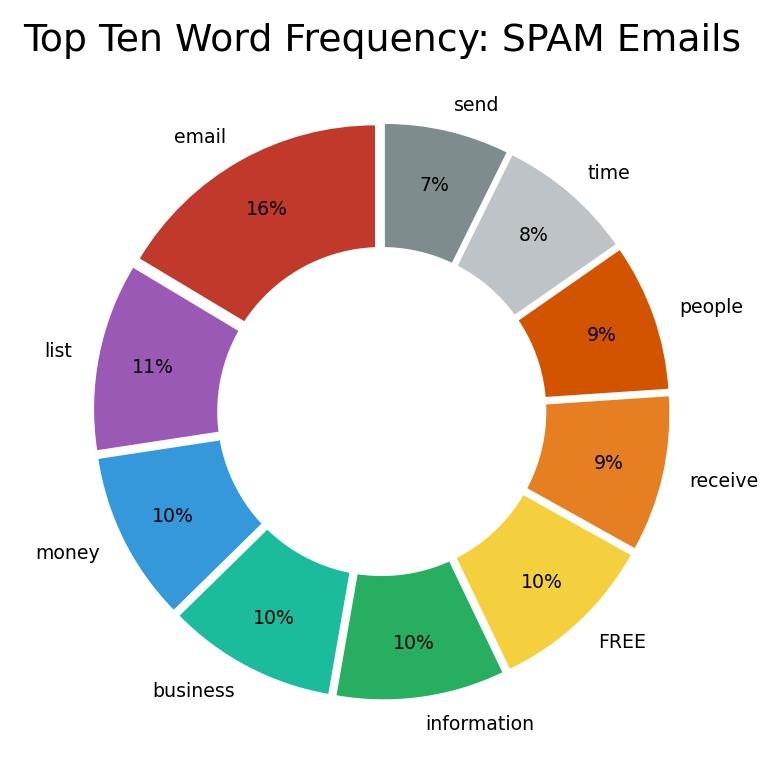

In [22]:
category_names = df_data_1["words of spam"]

sizes = SPAM_words[:10]
custom_colours = ['#C0392B', '#9B59B6', '#3498DB', '#1ABC9C', '#27AE60', 
                  '#F4D03F', '#E67E22','#D35400', '#BDC3C7', '#7F8C8D']

#to "explode"
offset = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(4, 4), dpi=227)
plt.pie(sizes, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours,  pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc='white')
plt.gca().add_artist(centre_circle)


#title

plt.title('Top Ten Word Frequency: SPAM Emails')

plt.show()

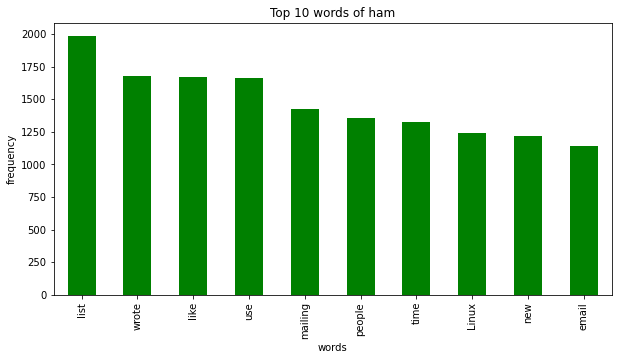

In [23]:
df_data_2.plot.bar(legend = False, color = 'green', figsize = (10,5))
y_pos = np.arange(len(df_data_2["words of ham"]))
plt.xticks(y_pos, df_data_2["words of ham"])
plt.title('Top 10 words of ham')
plt.xlabel('words')
plt.ylabel('frequency')
#plt.draw()
plt.legend().set_visible(False)

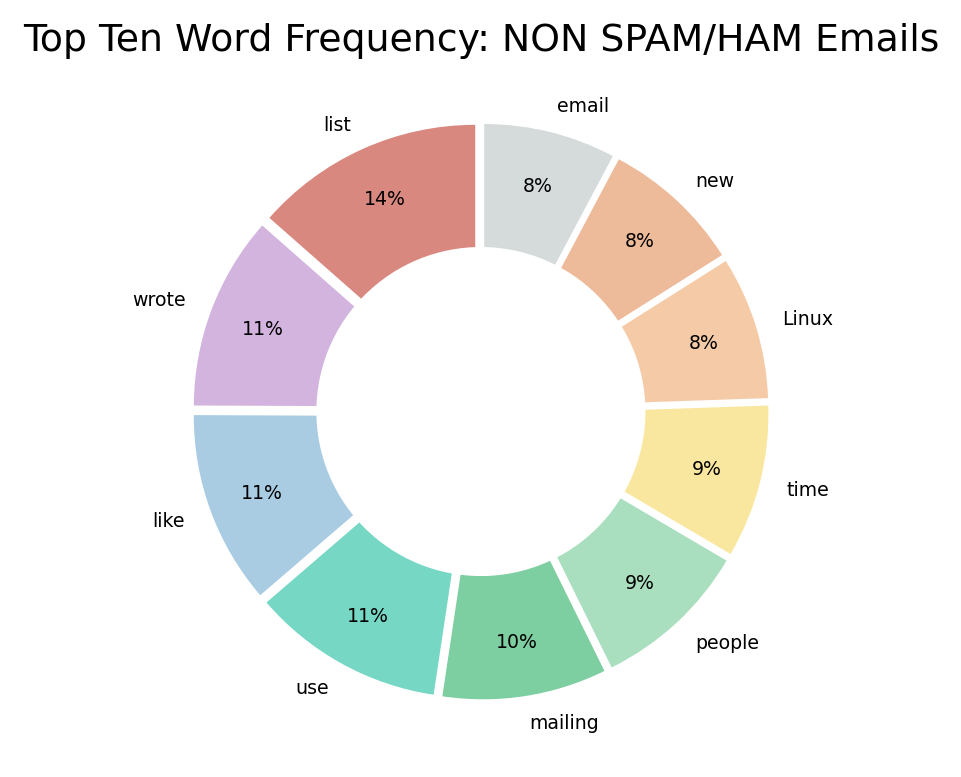

In [24]:
category_names = df_data_2["words of ham"]
#category_names = [word.upper() for word in category_names]

sizes = HAM_words[:10]
custom_colours = ['#D98880', '#D2B4DE', '#A9CCE3', '#76D7C4', '#7DCEA0', 
                  '#A9DFBF', '#F9E79F','#F5CBA7', '#EDBB99', '#D5DBDB']

#to "explode"
offset = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

def absolute_value(val):
    a  = sizes[ numpy.abs(sizes - val/100.*sizes.sum()).argmin() ]
    return a

plt.figure(figsize=(4, 4), dpi=227)

plt.pie(sizes, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours,  pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc='white')
plt.gca().add_artist(centre_circle)


#title
plt.title('Top Ten Word Frequency: NON SPAM/HAM Emails')

plt.show()

----------------------------------------------------------------------------------------------------------------------

# Data in 9:1 split & Create the Classifier

----------------------------------------------------------------------------------------------------------------------

In [25]:
# Creating a dataframe with 90%
# values of original dataframe
classifier_0_train = df_data.sample(frac = 0.90)
 
# Creating dataframe with
# rest of the 10% values
classifier_0_validate = df_data.drop(classifier_0_train.index)

#Train-Test-Split Data
X_train, X_test, y_train, y_test = train_test_split(classifier_0_train.MESSAGE, classifier_0_train.CATEGORY, 
                                                    test_size=0.3, random_state=43)

#Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25)

#TODO: unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#Create classifier with 90% of the data: 
spam_detector_svc_classifier_0 = SGDClassifier().fit(tfidf_train, y_train)

#Get Predictions
predictions_classifier_0 = spam_detector_svc_classifier_0.predict(tfidf_test)

Confusion Matrix


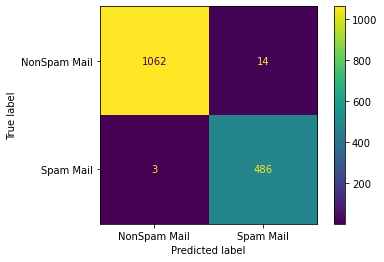

In [26]:
cm = confusion_matrix(predictions_classifier_0, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [27]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions_classifier_0, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions_classifier_0, digits=3, target_names=target_names)

Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.987     0.997     0.992      1065
   Spam Mail      0.994     0.972     0.983       500

    accuracy                          0.989      1565
   macro avg      0.990     0.985     0.987      1565
weighted avg      0.989     0.989     0.989      1565



Verify on the 10% split 

In [28]:
verify_classifier_0 = tfidf_vectorizer.transform(classifier_0_validate.MESSAGE)
validation_classifier_0 = spam_detector_svc_classifier_0.predict(verify_classifier_0)
verification_classifier_0 = classifier_0_validate.CATEGORY.to_numpy()

correct_doc_classifier_0 = (verification_classifier_0 == validation_classifier_0).sum()
numbs_doc_wrong_classifier_0 = verification_classifier_0.shape[0] - correct_doc_classifier_0
print('Docs classified correctly', correct_doc_classifier_0)
print('Docs classified incorrectly', numbs_doc_wrong_classifier_0)

Docs classified correctly 575
Docs classified incorrectly 5


Confusion Matrix


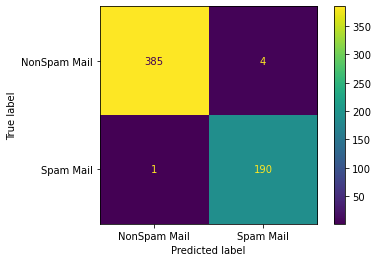

In [29]:
cm_validation_classifier_0 = confusion_matrix(validation_classifier_0, verification_classifier_0)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_validation_classifier_0, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [30]:
accuracy_c_0 = accuracy_score(y_test, predictions_classifier_0)
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(accuracy_c_0*100))

SGD Classifier Accuracy of the model: 98.914%


In [31]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score 
tnr_c_0 = recall_score(y_test, predictions_classifier_0) 
fnr_c_0 = 1 - tnr_c_0

print('False Negative Rate: {:.3f}%'.format(fnr_c_0)) 

False Negative Rate: 0.028%


In [32]:
#getting misclassified documents from of the emails used to train the classifier 

y__test_c_0 = np.asarray(y_test)
misclassified_c_0 = np.where(y__test_c_0 != predictions_classifier_0)
#print(misclassified_c_0)
#cleaning the missclassified data 
for x in misclassified_c_0: 
    misclass_data_c_0 = df_data.MESSAGE[x]
    misclass_data_c_0 = misclass_data_c_0.apply(clean_msg_nohtml)

In [33]:
#getting misclassified documents from of the emails used to verify the classifier
y__test_p_0 = np.asarray(verification_classifier_0)
misclassified_p_0 = np.where(y__test_p_0 != validation_classifier_0)
for x in misclassified_p_0: 
    misclass_data_p_0 = df_data.MESSAGE[x]
    misclass_data_p_0 = misclass_data_p_0.apply(clean_msg_nohtml)

In [34]:
misclass_data_p_0

Doc_ID
39     [Lowest, rates, available, term, life, insuran...
129    [favorite, Poker, action, Play, real, people, ...
164    [tired, spending, fortune, printer, cartridges...
191    [Market, Internet, Access, Investment, Needed,...
568    [BANNEDCD, NET, receiving, emails, saying, con...
Name: MESSAGE, dtype: object

----------------------------------------------------------------------------------------------------------------------

# Data in 4:1 split & Create the Classifier

----------------------------------------------------------------------------------------------------------------------

In [35]:
# Creating a dataframe with 80%
# values of original dataframe
classifier_1_train = df_data.sample(frac = 0.80)
 
# Creating dataframe with
# rest of the 20% values
classifier_1_validate = df_data.drop(classifier_1_train.index)

#Train-Test-Split Data
X_train, X_test, y_train, y_test = train_test_split(classifier_1_train.MESSAGE, classifier_1_train.CATEGORY, 
                                                    test_size=0.3, random_state=43)

#Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25)

#TODO: unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#Create classifier with 80% of the data: 
spam_detector_svc_classifier_1 = SGDClassifier().fit(tfidf_train, y_train)

#Get Predictions
predictions_classifier_1 = spam_detector_svc_classifier_1.predict(tfidf_test)

Confusion Matrix


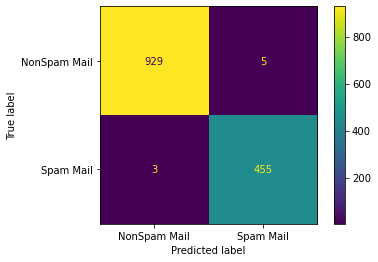

In [36]:
cm = confusion_matrix(predictions_classifier_1, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [37]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions_classifier_1, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions_classifier_1, digits=3, target_names=target_names)

Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.995     0.997     0.996       932
   Spam Mail      0.993     0.989     0.991       460

    accuracy                          0.994      1392
   macro avg      0.994     0.993     0.993      1392
weighted avg      0.994     0.994     0.994      1392



Verify on the 20% split 

In [38]:
verify_classifier_1 = tfidf_vectorizer.transform(classifier_1_validate.MESSAGE)
validation_classifier_1 = spam_detector_svc_classifier_1.predict(verify_classifier_1)
verification_classifier_1 = classifier_1_validate.CATEGORY.to_numpy()

correct_doc_classifier_1 = (verification_classifier_1 == validation_classifier_1).sum()
numbs_doc_wrong_classifier_1 = verification_classifier_1.shape[0] - correct_doc_classifier_1
print('Docs classified correctly', correct_doc_classifier_1)
print('Docs classified incorrectly', numbs_doc_wrong_classifier_1)

Docs classified correctly 1145
Docs classified incorrectly 14


Confusion Matrix


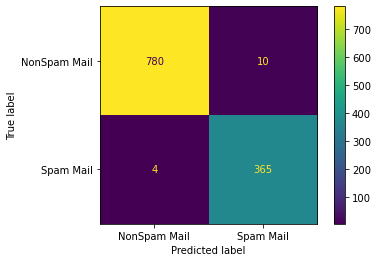

In [39]:
cm_validation_classifier_1 = confusion_matrix(validation_classifier_1, verification_classifier_1)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_validation_classifier_1, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [40]:
accuracy_c_1 = accuracy_score(y_test, predictions_classifier_1)
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(accuracy_c_1*100))

SGD Classifier Accuracy of the model: 99.425%


In [41]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score 
tnr_c_1 = recall_score(y_test, predictions_classifier_1) 
fnr_c_1 = 1 - tnr_c_1

print('False Negative Rate: {:.3f}%'.format(fnr_c_1)) 

False Negative Rate: 0.011%


In [42]:
#getting misclassified documents from of the emails used to train the classifier 

y__test_c_1 = np.asarray(y_test)
misclassified_c_1 = np.where(y__test_c_1 != predictions_classifier_1)
#print(misclassified_c_1)
#cleaning the missclassified data 
for x in misclassified_c_1: 
    misclass_data_c_1 = df_data.MESSAGE[x]
    misclass_data_c_1 = misclass_data_c_1.apply(clean_msg_nohtml)

In [43]:
#getting misclassified documents from of the emails used to verify the classifier
y__test_p_1 = np.asarray(verification_classifier_1)
misclassified_p_1 = np.where(y__test_p_1 != validation_classifier_1)
for x in misclassified_p_1: 
    misclass_data_p_1 = df_data.MESSAGE[x]
    misclass_data_p_1 = misclass_data_p_1.apply(clean_msg_nohtml)

----------------------------------------------------------------------------------------------------------------------

# Data in 3:1 split & Create the Classifier

----------------------------------------------------------------------------------------------------------------------

In [44]:
# Creating a dataframe with 75%
# values of original dataframe
classifier_2_train = df_data.sample(frac = 0.75)
 
# Creating dataframe with
# rest of the 25% values
classifier_2_validate = df_data.drop(classifier_2_train.index)

#Train-Test-Split Data
X_train, X_test, y_train, y_test = train_test_split(classifier_2_train.MESSAGE, classifier_2_train.CATEGORY, 
                                                    test_size=0.3, random_state=43)

#Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25)

#TODO: unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#Create classifier with 80% of the data: 
spam_detector_svc_classifier_2 = SGDClassifier().fit(tfidf_train, y_train)

#Get Predictions
predictions_classifier_2 = spam_detector_svc_classifier_2.predict(tfidf_test)

Confusion Matrix


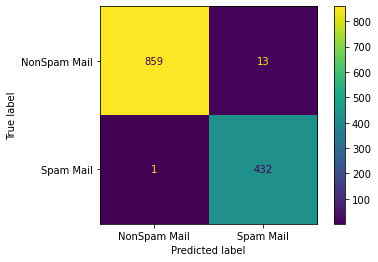

In [45]:
cm = confusion_matrix(predictions_classifier_2, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [46]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions_classifier_2, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions_classifier_2, digits=3, target_names=target_names)

Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.985     0.999     0.992       860
   Spam Mail      0.998     0.971     0.984       445

    accuracy                          0.989      1305
   macro avg      0.991     0.985     0.988      1305
weighted avg      0.989     0.989     0.989      1305



Verify on the 25%

In [47]:
verify_tfidf_test_classifier_2 = tfidf_vectorizer.transform(classifier_2_validate.MESSAGE)
validation_classifier_2 = spam_detector_svc_classifier_2.predict(verify_tfidf_test_classifier_2)
verification_classifier_2 = classifier_2_validate.CATEGORY.to_numpy()

correct_doc_val_c_2 = (verification_classifier_2 == validation_classifier_2).sum()
numbs_doc_wrong_val_c_2 = verification_classifier_2.shape[0] - correct_doc_val_c_2
print('Docs classified correctly', correct_doc_val_c_2)
print('Docs classified incorrectly', numbs_doc_wrong_val_c_2)

Docs classified correctly 1425
Docs classified incorrectly 24


Confusion Matrix


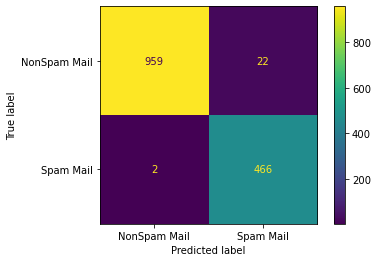

In [48]:
cm_validation_classifier_2 = confusion_matrix(validation_classifier_2, verification_classifier_2)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_validation_classifier_2, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [49]:
accuracy_c_2 = accuracy_score(y_test, predictions_classifier_2)
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(accuracy_c_2*100))

SGD Classifier Accuracy of the model: 98.927%


In [50]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score
tpr_c_2 = recall_score(y_test, predictions_classifier_2) 
fnr_c_2 = 1 - tpr_c_2

print('False Negative Rate: {:.3f}%'.format(fnr_c_2)) 

False Negative Rate: 0.029%


In [51]:
#getting misclassified documents from of the emails used to train the classifier
y__test_c_2 = np.asarray(y_test)
misclassified_c_2 = np.where(y__test_c_2 != predictions_classifier_2)
for x in misclassified_c_2: 
    misclass_data_c_2 = df_data.MESSAGE[x]
    misclass_data_c_2 = misclass_data_c_2.apply(clean_msg_nohtml)

In [52]:
#getting misclassified documents from of the emails used to verify the classifier
y__test_p_2 = np.asarray(verification_classifier_2)
misclassified_p_2 = np.where(y__test_p_2 != validation_classifier_2)
for x in misclassified_p_2: 
    misclass_data_p_2 = df_data.MESSAGE[x]
    misclass_data_p_2 = misclass_data_p_2.apply(clean_msg_nohtml)

----------------------------------------------------------------------------------------------------------------------

# Data in 50:50 split & Create the Classifier

----------------------------------------------------------------------------------------------------------------------

In [53]:
# Creating a dataframe with 50%
# values of original dataframe
classifier_3_train = df_data.sample(frac = 0.5)
 
# Creating dataframe with
# rest of the 50% values
classifier_3_test = df_data.drop(classifier_3_train.index)


#Train-Test-Split Data
X_train, X_test, y_train, y_test = train_test_split(classifier_3_train.MESSAGE, 
                                                    classifier_3_train.CATEGORY, 
                                                    test_size=0.3, random_state=43)

#Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25)

#TODO: unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#Create classifier with 50% of the data: 
spam_detector_svc_classifier_3 = SGDClassifier().fit(tfidf_train, y_train)

#Get Predictions
predictions_classifier_3 = spam_detector_svc_classifier_3.predict(tfidf_test)

Confusion Matrix


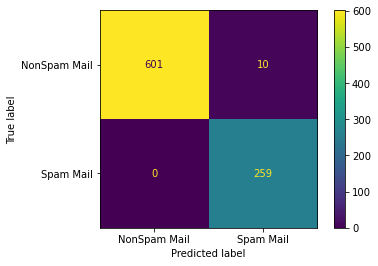

In [54]:
cm = confusion_matrix(predictions_classifier_3, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [55]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions_classifier_3, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions_classifier_3, digits=3, target_names=target_names)



Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.984     1.000     0.992       601
   Spam Mail      1.000     0.963     0.981       269

    accuracy                          0.989       870
   macro avg      0.992     0.981     0.986       870
weighted avg      0.989     0.989     0.988       870



Verify on the other 50% 

In [56]:
verify_tfidf_classifier_3 = tfidf_vectorizer.transform(classifier_3_test.MESSAGE)
validation_classifier_3 = spam_detector_svc_classifier_3.predict(verify_tfidf_classifier_3)
verification_classifier_3 = classifier_3_test.CATEGORY.to_numpy()

correct_doc_val_classifier_3 = (verification_classifier_3 == validation_classifier_3).sum()
numbs_doc_wrong_classifier_3 = verification_classifier_3.shape[0] - correct_doc_val_classifier_3
print('Docs classified correctly', correct_doc_val_classifier_3)
print('Docs classified incorrectly', numbs_doc_wrong_classifier_3)

Docs classified correctly 2842
Docs classified incorrectly 56


Confusion Matrix


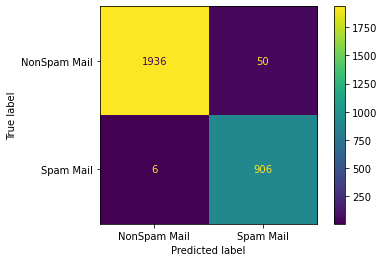

In [57]:
cm_validation_classifier_3 = confusion_matrix(validation_classifier_3, verification_classifier_3)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_validation_classifier_3, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [58]:
accuracy_c_3 = accuracy_score(y_test, predictions_classifier_3)
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(accuracy_c_3*100))

SGD Classifier Accuracy of the model: 98.851%


In [59]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score
tpr_c_3 = recall_score(y_test, predictions_classifier_3, average='weighted')
fnr_c_3 = 1 - tpr_c_3
print('False Negative Rate: {:.3f}%'.format(fnr_c_3))

False Negative Rate: 0.011%


In [60]:
#getting misclassified documents from of the emails used to train the classifier
y__test_c_3 = np.asarray(y_test)
misclassified_c_3 = np.where(y__test_c_3 != predictions_classifier_3)
for x in misclassified_c_3: 
    misclass_data_c_3 = df_data.MESSAGE[x]
    misclass_data_c_3 = misclass_data_c_3.apply(clean_msg_nohtml)

In [61]:
#getting misclassified documents from of the emails used to verify the classifier
y__test_p_3 = np.asarray(verification_classifier_3)
misclassified_p_3 = np.where(y__test_p_3 != validation_classifier_3)
for x in misclassified_p_3: 
    misclass_data_p_3 = df_data.MESSAGE[x]
    misclass_data_p_3 = misclass_data_p_3.apply(clean_msg_nohtml)

----------------------------------------------------------------------------------------------------------------------

# Data in 1:3 split & Create the Classifier

----------------------------------------------------------------------------------------------------------------------

In [62]:
# Creating a dataframe with 25%
# values of original dataframe
classifier_4_test = df_data.sample(frac = 0.25)
 
# Creating dataframe with
# rest of the 75% values
classifier_4_verify = df_data.drop(classifier_4_test.index)


#Train-Test-Split Data
X_train, X_test, y_train, y_test = train_test_split(classifier_4_test.MESSAGE, classifier_4_test.CATEGORY, 
                                                    test_size=0.3, random_state=43)

#Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25)

#TODO: unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#Create classifier with 25% of the data: 
spam_detector_svc_classifier_4 = SGDClassifier().fit(tfidf_train, y_train)

#Get Predictions
predictions_classifier_4 = spam_detector_svc_classifier_4.predict(tfidf_test)

Confusion Matrix


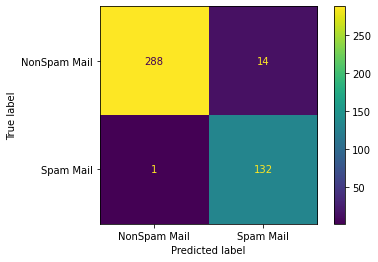

In [63]:
cm = confusion_matrix(predictions_classifier_4, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [64]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions_classifier_4, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions_classifier_4, digits=3, target_names=target_names)



Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.954     0.997     0.975       289
   Spam Mail      0.992     0.904     0.946       146

    accuracy                          0.966       435
   macro avg      0.973     0.950     0.960       435
weighted avg      0.967     0.966     0.965       435



Verify on the 75%

In [65]:
verify_tfidf_test = tfidf_vectorizer.transform(classifier_4_verify.MESSAGE)
validation_classifier_4 = spam_detector_svc_classifier_4.predict(verify_tfidf_test)
verification_classifier_4 = classifier_4_verify.CATEGORY.to_numpy()

correct_doc_val_classifier_4 = (verification_classifier_4 == validation_classifier_4).sum()
numbs_doc_wrong_val_classifier_4 = verification_classifier_4.shape[0] - correct_doc_val_classifier_4
print('Docs classified correctly', correct_doc_val_classifier_4)
print('Docs classified incorrectly', numbs_doc_wrong_val_classifier_4)

Docs classified correctly 4259
Docs classified incorrectly 88


Confusion Matrix


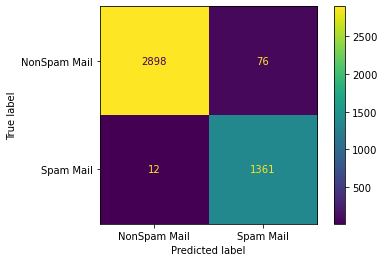

In [66]:
cm_validation_classifier_4 = confusion_matrix(validation_classifier_4, verification_classifier_4)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_validation_classifier_4, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [67]:
accuracy_c_4 = accuracy_score(y_test, predictions_classifier_4)
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(accuracy_c_4*100))

SGD Classifier Accuracy of the model: 96.552%


In [68]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score
tnr_c_4 = recall_score(y_test, predictions_classifier_4, average='weighted')
fnr_c_4 = 1 - tnr_c_4

print('False Negative Rate: {:.3f}%'.format(fnr_c_4)) 

False Negative Rate: 0.034%


In [69]:
#getting misclassified documents from of the emails used to train the classifier
y__test_c_4 = np.asarray(y_test)
misclassified_c_4 = np.where(y__test_c_4 != predictions_classifier_4)
for x in misclassified_c_4: 
    misclass_data_c_4 = df_data.MESSAGE[x]
    misclass_data_c_4 = misclass_data_c_4.apply(clean_msg_nohtml)

In [70]:
#getting misclassified documents from of the emails used to verify the classifier
y__test_p_4 = np.asarray(verification_classifier_4)
misclassified_p_4 = np.where(y__test_p_4 != validation_classifier_4)
for x in misclassified_p_4: 
    misclass_data_p_4 = df_data.MESSAGE[x]
    misclass_data_p_4 = misclass_data_p_4.apply(clean_msg_nohtml)

----------------------------------------------------------------------------------------------------------------------

# Data split 1:9 & Create the Classifier

----------------------------------------------------------------------------------------------------------------------

In [71]:
# Creating a dataframe with 10%
# values of original dataframe
classifier_5_test = df_data.sample(frac = 0.10)
 
# Creating dataframe with
# rest of the 90% values
classifier_5_verify = df_data.drop(classifier_5_test.index)


#Train-Test-Split Data
X_train, X_test, y_train, y_test = train_test_split(classifier_5_test.MESSAGE, classifier_5_test.CATEGORY, 
                                                    test_size=0.3, random_state=43)

#Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25)

#TODO: unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#Create classifier with 10% of the data: 
spam_detector_svc_classifier_5 = SGDClassifier().fit(tfidf_train, y_train)

#Get Predictions
predictions_classifier_5 = spam_detector_svc_classifier_5.predict(tfidf_test)

Confusion Matrix


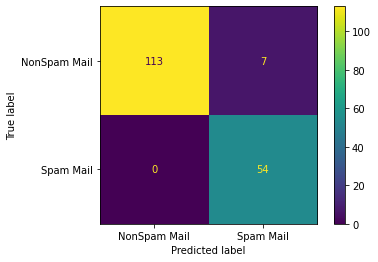

In [72]:
cm = confusion_matrix(predictions_classifier_5, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [73]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions_classifier_5, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions_classifier_5, digits=3, target_names=target_names)


Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.942     1.000     0.970       113
   Spam Mail      1.000     0.885     0.939        61

    accuracy                          0.960       174
   macro avg      0.971     0.943     0.955       174
weighted avg      0.962     0.960     0.959       174



Verify on the 90% 

In [74]:
verify_tfidf_test = tfidf_vectorizer.transform(classifier_5_verify.MESSAGE)
validation_classifier_5 = spam_detector_svc_classifier_5.predict(verify_tfidf_test)
verification_classifier_5 = classifier_5_verify.CATEGORY.to_numpy()

correct_doc_val_classifier_5 = (verification_classifier_5 == validation_classifier_5).sum()
numbs_doc_wrong_val_classifier_5 = verification_classifier_5.shape[0] - correct_doc_val_classifier_5
print('Docs classified correctly', correct_doc_val_classifier_5)
print('Docs classified incorrectly', numbs_doc_wrong_val_classifier_5)

Docs classified correctly 4963
Docs classified incorrectly 253


Confusion Matrix


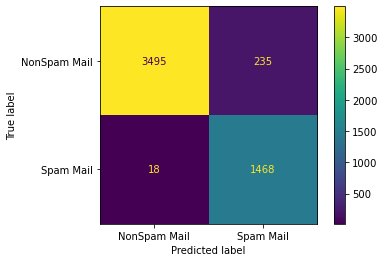

In [75]:
cm_validation_classifier_5 = confusion_matrix(validation_classifier_5, verification_classifier_5)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_validation_classifier_5, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [76]:
accuracy_c_5 = accuracy_score(y_test, predictions_classifier_5)
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(accuracy_c_5*100))

SGD Classifier Accuracy of the model: 95.977%


In [77]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score
tpr_c_5 = recall_score(y_test, predictions_classifier_5, average='weighted')
fnr_c_5 = 1 - tpr_c_5

print('False Negative Rate: {:.3f}%'.format(fnr_c_5)) 

False Negative Rate: 0.040%


In [78]:
#getting misclassified documents from of the emails used to train the classifier
y__test_c_5 = np.asarray(y_test)
misclassified_c_5 = np.where(y__test_c_5 != predictions_classifier_5)
for x in misclassified_c_5: 
    misclass_data_c_5 = df_data.MESSAGE[x]
    misclass_data_c_5 = misclass_data_c_5.apply(clean_msg_nohtml)

In [79]:
#getting misclassified documents from of the emails used to verify the classifier
y__test_p_5 = np.asarray(verification_classifier_5)
misclassified_p_5 = np.where(y__test_p_5 != validation_classifier_5)
for x in misclassified_p_5: 
    misclass_data_p_5 = df_data.MESSAGE[x]
    misclass_data_p_5 = misclass_data_p_5.apply(clean_msg_nohtml)

----------------------------------------------------------------------------------------------------------------------

# Using 100% of the Data

----------------------------------------------------------------------------------------------------------------------

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df_data.MESSAGE, df_data.CATEGORY, 
                                                    test_size=0.3, random_state=43)

In [81]:
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25) 
# unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [82]:
#CREATE SPAM DETECTOR
spam_detector_svc_OG = SGDClassifier().fit(tfidf_train, y_train) 
#SGDclassifier is part of sklearn package - linear classifier, sensitive to feature scaling. 
#technically a SVM linear classifier, the training algorithm using ...
#check its loss functions (similar to neural network)
predictions_OG = spam_detector_svc_OG.predict(tfidf_test)

Confusion Matrix


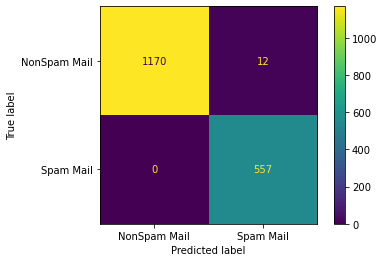

In [83]:
cm = confusion_matrix(predictions_OG, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [84]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score 
# Specificity or true negative rate
tnr_OG = recall_score(y_test, predictions_OG, average='weighted')
# False negative rate
fnr_OG = 1 - tnr_OG

print('False Negative Rate: {:.3f}%'.format(fnr_OG))   #FNR for 1st class will be at index 0

False Negative Rate: 0.007%


In [85]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions_OG, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions_OG, digits=3, target_names=target_names)

Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.990     1.000     0.995      1170
   Spam Mail      1.000     0.979     0.989       569

    accuracy                          0.993      1739
   macro avg      0.995     0.989     0.992      1739
weighted avg      0.993     0.993     0.993      1739



In [86]:
correct_doc = (y_test == predictions_OG).sum()
numbs_doc_wrong = X_test.shape[0] - correct_doc
print('Docs classified correctly', correct_doc)
print('Docs classified incorrectly', numbs_doc_wrong)

# fraction_wrong = numbs_doc_wrong/ (correct_doc +numbs_doc_wrong)
# print(f' The (testing) accuracy of the model is {1-fraction_wrong:.3%}')

accuracy_OG = accuracy_score(y_test, predictions_OG)
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(accuracy_OG*100))

Docs classified correctly 1727
Docs classified incorrectly 12
SGD Classifier Accuracy of the model: 99.310%


In [87]:
#getting misclassified documents from of the emails used to train the classifier
y__test_OG = np.asarray(y_test)
misclassified_OG = np.where(y__test_OG != predictions_OG)

for x in misclassified_OG: 
    misclass_data_OG = df_data.MESSAGE[x]
    misclass_data_OG = misclass_data_OG.apply(clean_msg_nohtml)

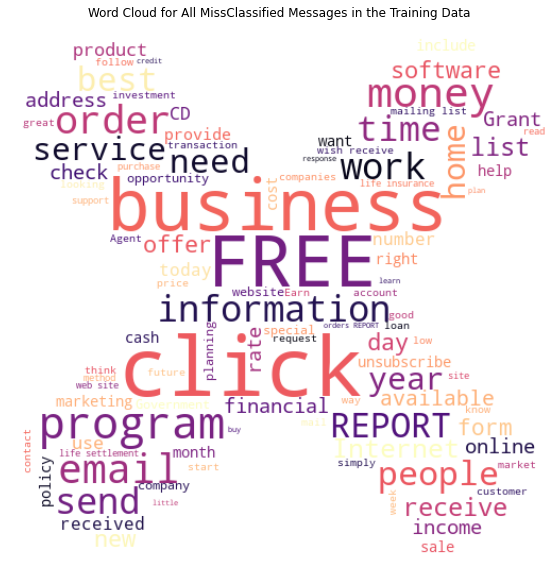

In [88]:
#adding all text from the cleaned misclassified training data into one string for data visualisation 
cleaned_misclass_string = ""

for x in misclass_data_c_0:
    cleaned_misclass_string += (' '.join(x))

for x in misclass_data_c_1:
    cleaned_misclass_string += (' '.join(x))

for x in misclass_data_c_2:
    cleaned_misclass_string += (' '.join(x))

for x in misclass_data_c_3:
    cleaned_misclass_string += (' '.join(x))

for x in misclass_data_c_4:
    cleaned_misclass_string += (' '.join(x))

for x in misclass_data_c_5:
    cleaned_misclass_string += (' '.join(x))
    
for x in misclass_data_OG:
    cleaned_misclass_string += (' '.join(x))
    
icon = Image.open(X_ICON)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 100, colormap = 'magma')

word_cloud.generate(cleaned_misclass_string)

plt.figure(figsize=[16,10])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for All MissClassified Messages in the Training Data')
plt.axis('off')
plt.show()

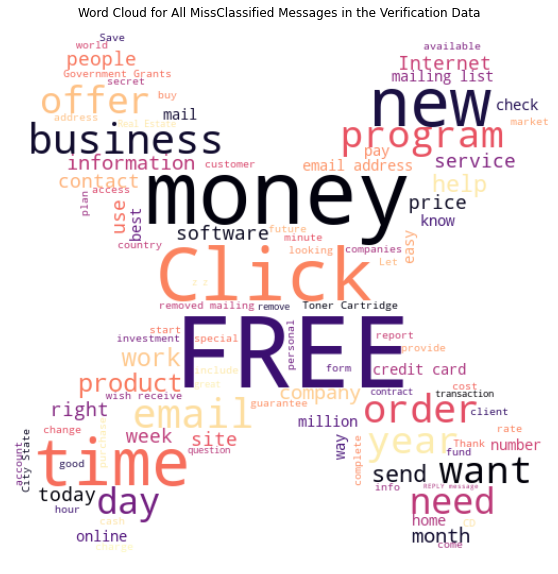

In [89]:
#adding all text from the cleaned misclassified verification data into one string for data visualisation 
cleaned_misclass_string_verification_data = ''

for x in misclass_data_p_0:
    cleaned_misclass_string_verification_data += (' '.join(x))

for x in misclass_data_p_1:
    cleaned_misclass_string_verification_data += (' '.join(x))

for x in misclass_data_p_2:
    cleaned_misclass_string_verification_data += (' '.join(x))

for x in misclass_data_p_3:
    cleaned_misclass_string_verification_data += (' '.join(x))

for x in misclass_data_p_4:
    cleaned_misclass_string_verification_data += (' '.join(x))

for x in misclass_data_p_5:
    cleaned_misclass_string_verification_data += (' '.join(x))
    
# for x in misclass_data_OG:
#     cleaned_misclass_string += (' '.join(x))
    
icon = Image.open(X_ICON)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 100, colormap = 'magma')

word_cloud.generate(cleaned_misclass_string_verification_data)

plt.figure(figsize=[16,10])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for All MissClassified Messages in the Verification Data')
plt.axis('off')
plt.show()

In [90]:
#FOR THE MISCLASSIFIED TRAINING DATA 
counted_misclass = Counter(pd.Series(cleaned_misclass_string).str.split().sum())
missclass_data1 = pd.DataFrame.from_dict(Counter(cleaned_misclass_string.split()).most_common(5))
missclass_data1 = missclass_data1.rename(columns={0: "words of missclassed training data", 1 : "count"})

#FOR THE MISCLASSIFIED VERIFICATIOIN DATA 
counted_misclass = Counter(pd.Series(cleaned_misclass_string_verification_data).str.split().sum())
missclass_data2 = pd.DataFrame.from_dict(Counter(cleaned_misclass_string_verification_data.split()).most_common(5))
missclass_data2 = missclass_data2.rename(columns={0: "words of missclassed verification data", 1 : "count"})

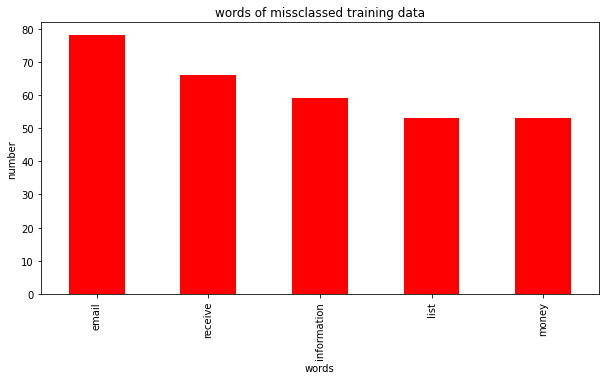

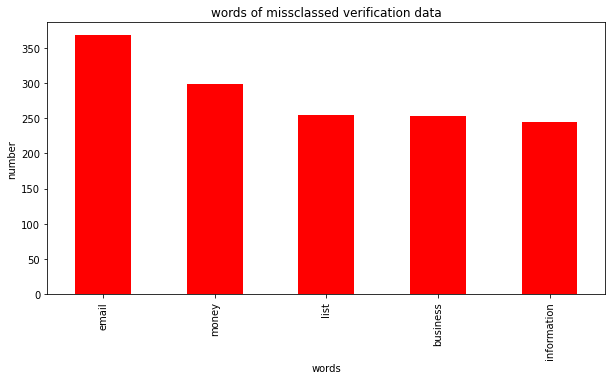

In [91]:
#FOR THE MISCLASSIFIED TRAINING DATA 
missclass_data1.plot.bar(legend = False, color = 'red', figsize = (10,5))
y_pos = np.arange(len(missclass_data1["words of missclassed training data"]))
plt.xticks(y_pos, missclass_data1["words of missclassed training data"])
plt.title('words of missclassed training data')
plt.xlabel('words')
plt.ylabel('number')
plt.draw()
plt.legend().set_visible(False)

#FOR THE MISCLASSIFIED VERIFICATIOIN DATA 
missclass_data2.plot.bar(legend = False, color = 'red', figsize = (10,5))
y_pos = np.arange(len(missclass_data2["words of missclassed verification data"]))
plt.xticks(y_pos, missclass_data2["words of missclassed verification data"])
plt.title('words of missclassed verification data')
plt.xlabel('words')
plt.ylabel('number')
plt.draw()
plt.legend().set_visible(False)

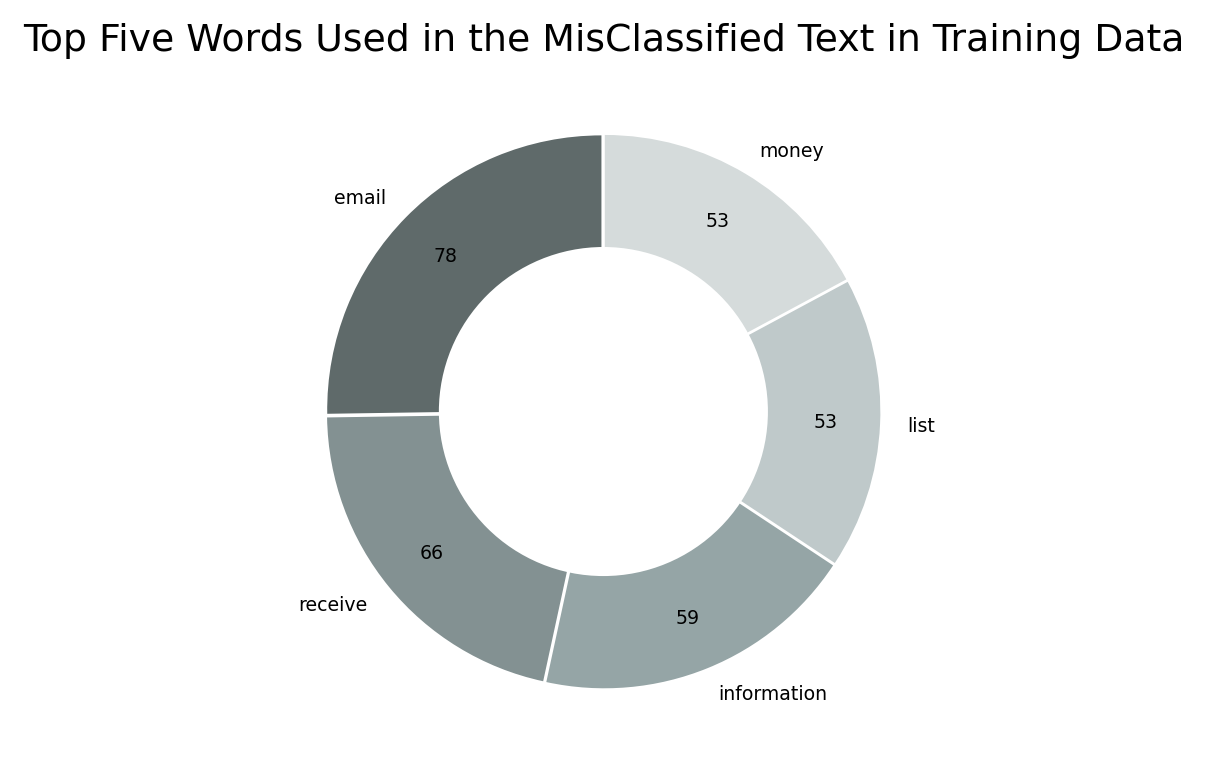

In [92]:
category_names = missclass_data1["words of missclassed training data"]

sizes = missclass_data1["count"]

custom_colours = ['#5F6A6A', '#839192', '#95A5A6',  '#BFC9CA', '#D5DBDB']

#to "explode"
offset = [0.01, 0.01, 0.01, 0.01, 0.01]

def absolute_value(val):
    a  = sizes[ np.abs(sizes - val/100.*sizes.sum()).argmin() ]
    return a

plt.figure(figsize=(4, 4), dpi=227)
plt.pie(sizes, labels = category_names, textprops = {'fontsize':6}, startangle = 90, 
        autopct = absolute_value, colors = custom_colours, pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)


#title
plt.title('Top Five Words Used in the MisClassified Text in Training Data')

plt.show()

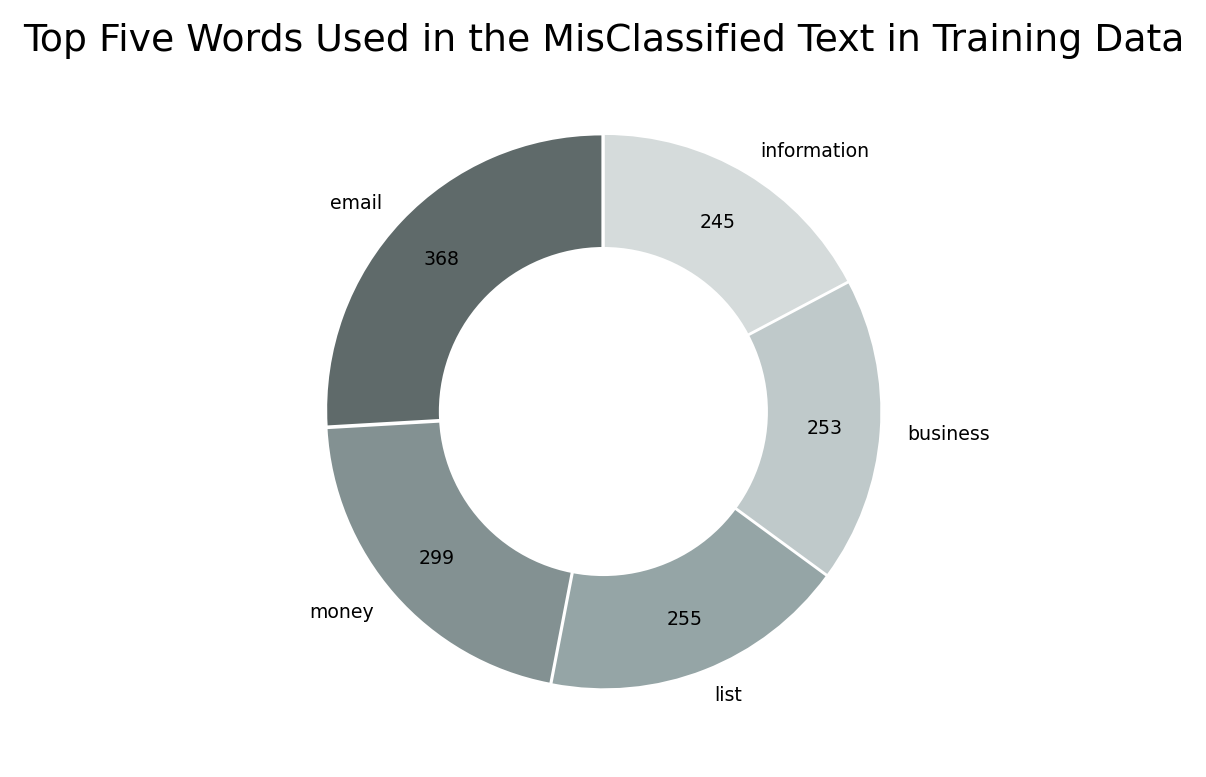

In [93]:
category_names = missclass_data2["words of missclassed verification data"]

sizes = missclass_data2["count"]

custom_colours = ['#5F6A6A', '#839192', '#95A5A6',  '#BFC9CA', '#D5DBDB']

#to "explode"
offset = [0.01, 0.01, 0.01, 0.01, 0.01]

def absolute_value(val):
    a  = sizes[ np.abs(sizes - val/100.*sizes.sum()).argmin() ]
    return a

plt.figure(figsize=(4, 4), dpi=227)
plt.pie(sizes, labels = category_names, textprops = {'fontsize':6}, startangle = 90, 
        autopct = absolute_value, colors = custom_colours, pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)


#title
plt.title('Top Five Words Used in the MisClassified Text in Training Data')

plt.show()

In [94]:
all_classifier_accuracy = {accuracy_c_0, accuracy_c_1, accuracy_c_2, accuracy_c_3, accuracy_c_4, accuracy_c_5, accuracy_OG}
classifier_accuracy = (sum(all_classifier_accuracy)/len(all_classifier_accuracy))*100
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(classifier_accuracy))

all_false_neg = {fnr_c_0, fnr_c_1, fnr_c_2, fnr_c_3, fnr_c_4, fnr_c_5, fnr_OG}
fals_neg = (sum(all_false_neg)/len(all_false_neg))*100
print('False Negative Rate: {:.3f}%'.format(fals_neg))

SGD Classifier Accuracy of the model: 98.279%
False Negative Rate: 2.303%


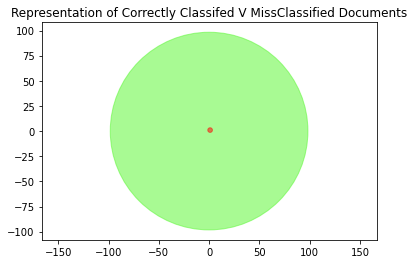

In [95]:
fig, ax = plt.subplots()
ax.add_patch(plt.Circle((0, 0), classifier_accuracy, color='#52F729', alpha=0.5))
ax.add_patch(plt.Circle((1, 1), fals_neg, color='red', alpha=0.5))

ax.set_aspect('equal', adjustable='datalim')
plt.title('Representation of Correctly Classifed V MissClassified Documents')
#plt.axis('off')
ax.plot()   #Causes an autoscale update.
plt.show()
